In [1]:
import numpy as np
import pandas as pd

import pystan
import arviz

import matplotlib.pyplot as plt

In [2]:
smoking_data = pd.read_table("../utilities_and_data/smoking/smoke_pub.dat")

In [25]:
smoking_data["mean_waves_smoked"] = smoking_data.groupby("newid")["smkreg"].transform("mean")
never_smokers = smoking_data["mean_waves_smoked"] == 0
# always_smokers = smoking_data["mean_waves_smoked"] == 1

never_smokers_test_statistic_y = (smoking_data.groupby("newid")["smkreg"].agg("mean") == 0).mean()
always_smokers_test_statistic_y = (smoking_data.groupby("newid")["smkreg"].agg("mean") == 1).mean()

In [4]:
def is_incident_smoker(arr):
    if arr[0] == 1:
        return False
    try:
        first_idx = np.argwhere(arr == 1)[0][0]
        return np.mean(arr[first_idx:len(arr)]) == 1
    except IndexError as ex:
        return False

In [39]:
def pct_incident_smokers(df):
    person_ids = df["newid"].unique()
    incident_smokers = []
    for idx in person_ids:
        person_df = df.copy().loc[df["newid"] == idx]
        if len(person_df) <= 1:
            continue
        if is_incident_smoker(person_df["smkreg"].values):
            incident_smokers.append(idx)
    return len(incident_smokers)/len(person_ids)

In [40]:
incident_smokers_test_statistic_y = pct_incident_smokers(smoking_data)

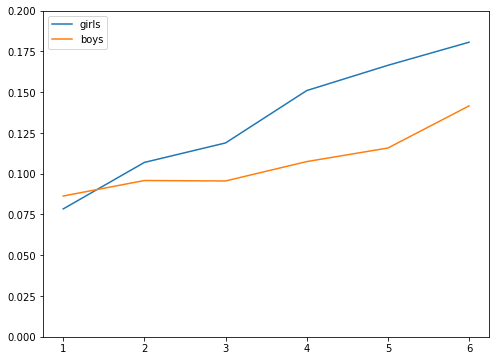

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(smoking_data.loc[smoking_data["sex(1=F)"] == 1].groupby("wave")["smkreg"].mean(), label="girls");
ax.plot(smoking_data.loc[smoking_data["sex(1=F)"] == 0].groupby("wave")["smkreg"].mean(), label="boys");
ax.set_ylim(0, 0.2);
ax.legend();

In [8]:
num_people = smoking_data["newid"].nunique()

In [9]:
model = pystan.StanModel("model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52da785ba2d5c6dcbc70f8adaa0fd65d NOW.


In [10]:
stan_data = {
    "N_people": num_people,
    "N": len(smoking_data),
    "parent_smoke": smoking_data["parsmk"],
    "female": smoking_data["sex(1=F)"],
    "t": smoking_data["wave"],
    "smoke": smoking_data["smkreg"],
    "p_idx": smoking_data["newid"]
}

In [11]:
fit = model.sampling(stan_data, iter=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
params = fit.extract(permuted=True)
var_names=["b0", "b1", "b2", "b3", "b4", "sigma_alpha"]

In [13]:
inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data, var_names=var_names)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [14]:
summary_df.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b0,-8.520,0.501,-9.468,-7.587,0.020,0.014,599.0,599.0,595.0,1093.0,1.01
1,b1,2.571,0.359,1.906,3.238,0.015,0.011,587.0,582.0,591.0,885.0,1.01
2,b2,-0.459,0.442,-1.298,0.340,0.015,0.011,855.0,855.0,856.0,1470.0,1.00
3,b3,0.355,0.054,0.261,0.464,0.001,0.001,3407.0,3321.0,3408.0,1916.0,1.00
4,b4,0.529,0.052,0.431,0.626,0.001,0.001,3276.0,3205.0,3273.0,1532.0,1.00
5,sigma_alpha,5.002,0.283,4.511,5.561,0.012,0.008,596.0,596.0,595.0,1234.0,1.01


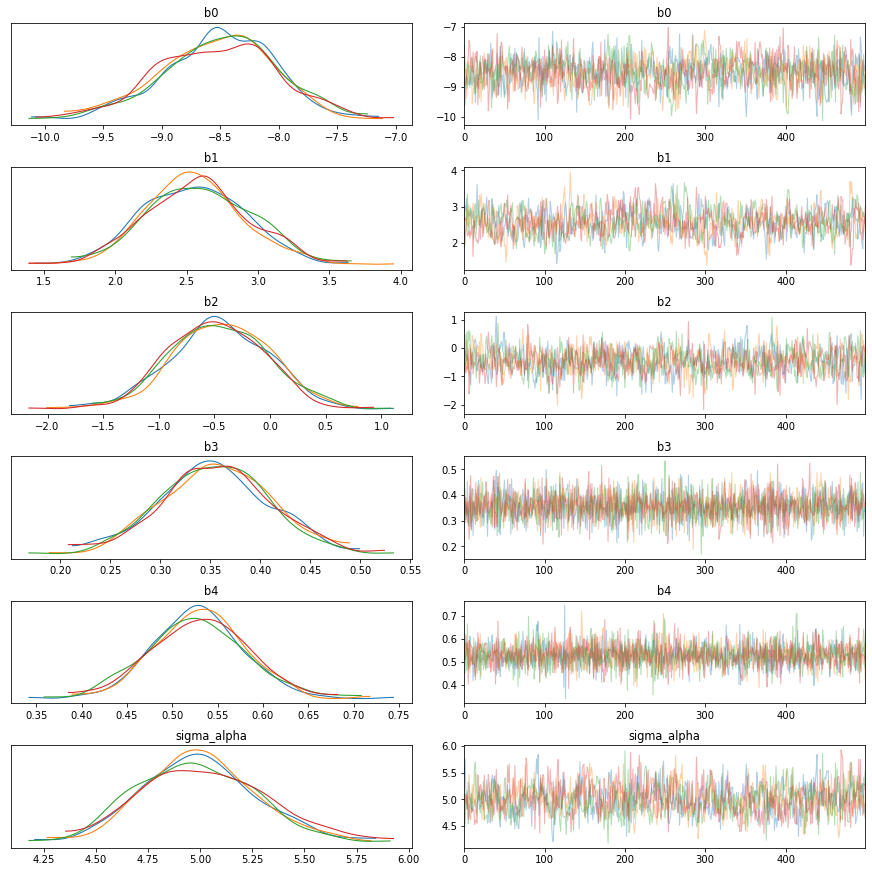

In [15]:
arviz.plot_trace(fit, var_names=var_names);

In [30]:
df_y_rep = pd.DataFrame(params["y_pred"]).T
df_y_rep["newid"] = smoking_data["newid"].values

In [31]:
never_smokers_y_rep = df_y_rep.groupby("newid").sum().values
never_smokers_test_statistic = (never_smokers_y_rep == 0).mean(0)
qs = np.quantile(never_smokers_test_statistic, q=[0.025, 0.975])

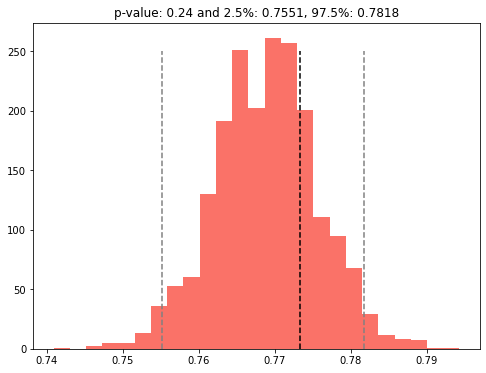

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(never_smokers_test_statistic, bins=25, color="#fa7268");
ax.vlines(qs[0], 0, 250, linestyle="--", color="grey");
ax.vlines(qs[1], 0, 250, linestyle="--", color="grey");
ax.vlines(never_smokers_test_statistic_y, 0, 250, linestyle="--", label="$T(y)$");
ax.set_title(f"p-value: {(np.mean(never_smokers_test_statistic > never_smokers_test_statistic_y)):.2f} and 2.5%: {qs[0]:.4f}, 97.5%: {qs[1]:.4f}");

In [33]:
always_smokers_y_rep = df_y_rep.groupby("newid").mean().values
always_smokers_test_statistic = (always_smokers_y_rep == 1).mean(0)
qs = np.quantile(always_smokers_test_statistic, q=[0.025, 0.975])

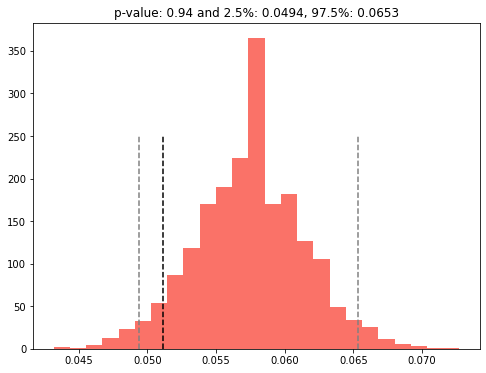

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(always_smokers_test_statistic, bins=25, color="#fa7268");
ax.vlines(qs[0], 0, 250, linestyle="--", color="grey");
ax.vlines(qs[1], 0, 250, linestyle="--", color="grey");
ax.vlines(always_smokers_test_statistic_y, 0, 250, linestyle="--", label="$T(y)$");
ax.set_title(f"p-value: {(np.mean(always_smokers_test_statistic > always_smokers_test_statistic_y)):.2f} and 2.5%: {qs[0]:.4f}, 97.5%: {qs[1]:.4f}");

In [49]:
ts = []
for i in range(params["y_pred"].shape[0]):
    if i % 50 == 0:
        print(i)
    tmp_df = pd.DataFrame({"smkreg": params["y_pred"][i], "newid": df_y_rep["newid"]})
    ts.append(pct_incident_smokers(tmp_df))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [51]:
np.quantile(ts, q=[0.025, 0.975])

array([0.05339489, 0.07840909])

In [54]:
np.mean(np.array(ts) > incident_smokers_test_statistic_y)

0.0045

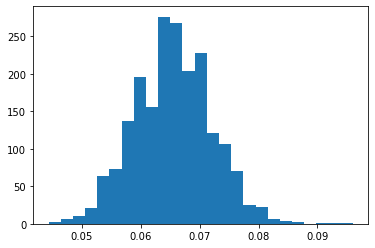

In [50]:
plt.hist(ts, bins=25);